## 1. Вступление

Сайт запустил A/B-тест с целью увеличения дохода.

Задача — проанализировать результаты эксперимента и написать свои рекомендации.

Ссылка на данные: https://www.kaggle.com/datasets/sergylog/ab-test-data/data

## 2. Данные и переменные

Файл Excel содержит необработанные данные о результатах эксперимента (**user_id**), типе выборки (**variant_name**) и доходе, принесенном пользователем (**revenue**).

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

In [56]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [57]:
PATH = ''
IS_COLAB = True

if IS_COLAB:
    PATH = '/drive/MyDrive/Analytics/Practice Case/AB_Test_Results.csv'

In [58]:
data = pd.read_csv(PATH)
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Для удобства переименуем названия колонок.

In [59]:
data = data.rename(columns={'USER_ID': 'user_id',
                            'VARIANT_NAME': 'variant_name',
                            'REVENUE': 'revenue'})
data.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


## 3. Анализ данных

Немного причешем наши данные.

In [60]:
data.shape

(10000, 3)

In [61]:
data.isnull().sum()

user_id         0
variant_name    0
revenue         0
dtype: int64

In [62]:
data.dropna(inplace=True)

In [63]:
data.describe()

,user_id,revenue
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Проверим наши данные на дубликаты.

In [64]:
data.duplicated().sum()

2067

In [65]:
data_unique = data.drop_duplicates()

In [66]:
data_unique.shape

(7933, 3)

Теперь посмотрим на пользователей. Сколько из них уникальных? Есть ли выбросы? Сколько из них относятся к контрольной и тестовой группам?

In [67]:
data.user_id.nunique()

6324

Записей в таблице больше, чем уникальных пользователей. Это может говорить о том, что некоторые более "активны", чем другие, или что часть пользователей принадлежит обеим группам. Проверим это.

In [68]:
varient_users = data.groupby('user_id') \
    .variant_name.nunique().value_counts().to_frame()
varient_users = varient_users.rename(columns={'variant_name': 'user_count'})
varient_users

,user_count
1,4783
2,1541


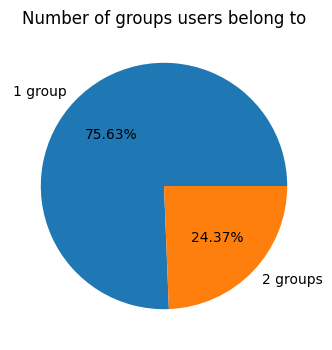

In [69]:
plt.figure(figsize=(4,4))
plt.pie(x=varient_users.user_count, labels=['1 group', '2 groups'], autopct='%.2f%%')
plt.title('Number of groups users belong to', size=12)
plt.show()

Видно, что чуть больше 24% пользователей принадлежат двум группам сразу. Поэтому уберём их из рассмотрения и будем проводить A/B-тест только на пользователях с 1 группой.

In [70]:
is_single_user = data.groupby('user_id').variant_name.nunique() == 1
is_single_user = is_single_user[is_single_user]

In [71]:
data = data[data['user_id'].isin(is_single_user.index)]
data.user_id.nunique()

4783

Теперь посмотрим на распределение данных.

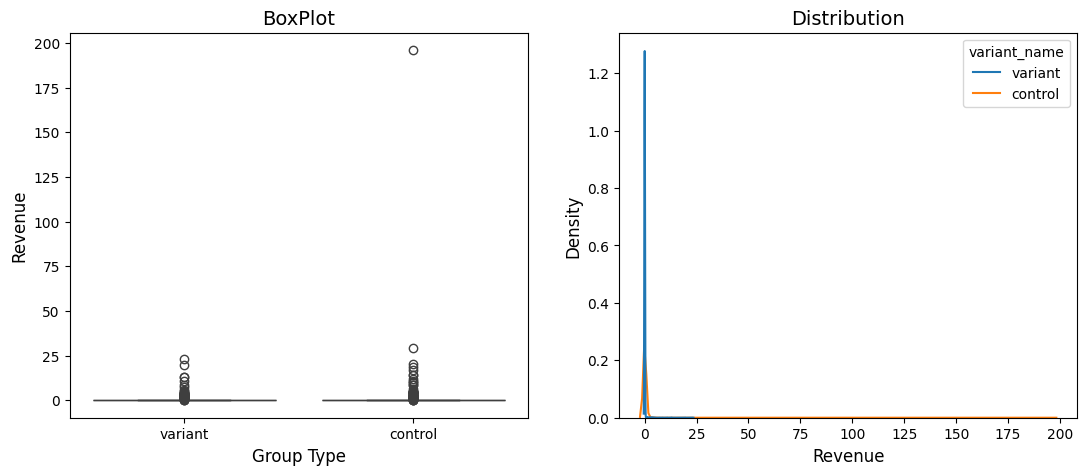

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(x='variant_name', y='revenue', data=data, ax=ax1)
ax1.set_xlabel("Group Type",size=12)
ax1.set_ylabel("Revenue",size=12)
ax1.set_title("BoxPlot",size=14)

sns.kdeplot(x='revenue', data=data, hue='variant_name')
ax2.set_xlabel("Revenue",size=12)
ax2.set_ylabel("Density",size=12)
ax2.set_title("Distribution",size=14)
plt.show()

Видно, что в контрольной группе есть выброс. Уберём его.

In [73]:
data.sort_values(by='revenue', ascending=False).head()

,user_id,variant_name,revenue
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [74]:
data = data[data['revenue'] != max(data['revenue'])]

Посмотрим на распределение ещё раз.

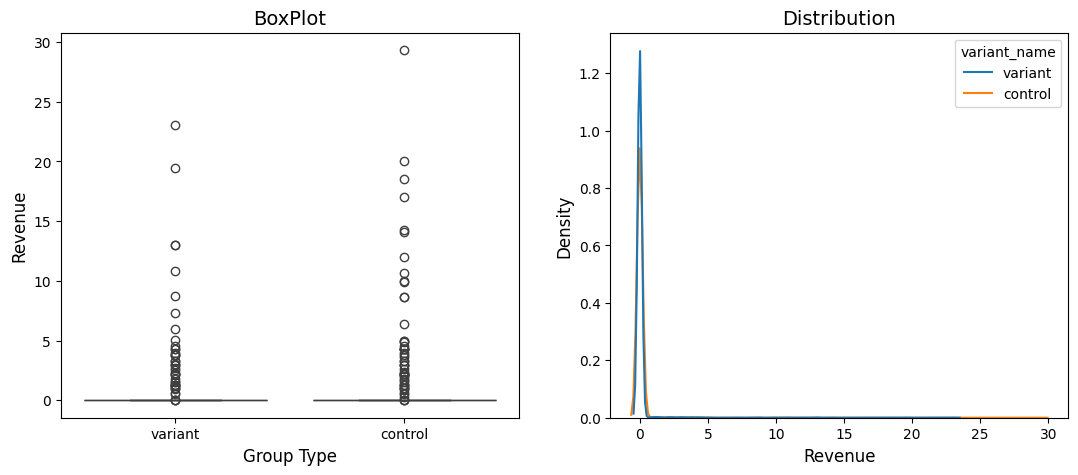

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(x='variant_name', y='revenue', data=data, ax=ax1)
ax1.set_xlabel("Group Type",size=12)
ax1.set_ylabel("Revenue",size=12)
ax1.set_title("BoxPlot",size=14)

sns.kdeplot(x='revenue', data=data, hue='variant_name')
ax2.set_xlabel("Revenue",size=12)
ax2.set_ylabel("Density",size=12)
ax2.set_title("Distribution",size=14)
plt.show()

Видно, что огромное количество пользователей ничего не покупали. То есть они просто заходили на сайт и выходили. Посмотрим, сколько пользователей, у которых суммарная выручка нулевая.

In [76]:
data_sum = data.groupby(['user_id', 'variant_name']).sum().reset_index()

In [77]:
(data_sum.revenue == 0).value_counts().to_frame()

,revenue
True,4687
False,95


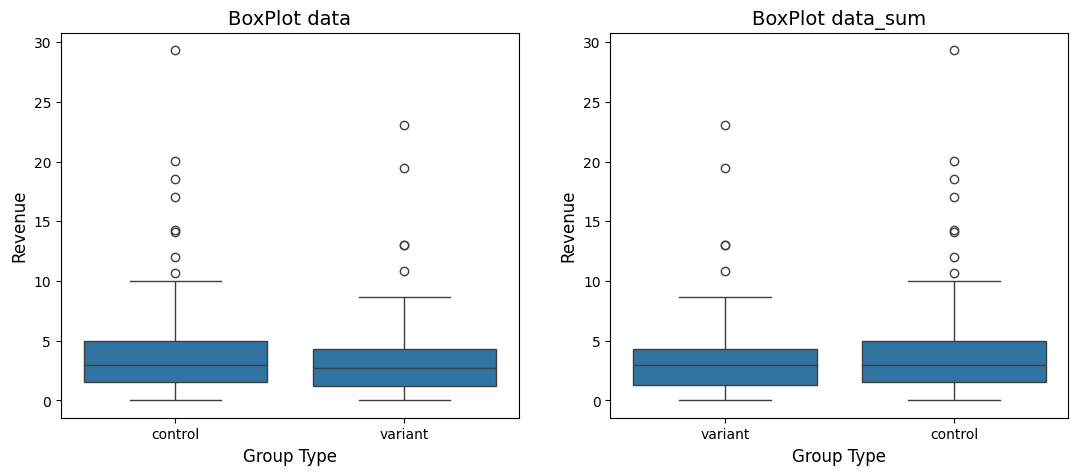

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

sns.boxplot(ax=ax1, x='variant_name', y='revenue', data = data[data.revenue > 0])
ax1.set_xlabel("Group Type",size=12)
ax1.set_ylabel("Revenue",size=12)
ax1.set_title("BoxPlot data",size=14)

sns.boxplot(ax=ax2, x='variant_name', y='revenue', data = data_sum[data_sum.revenue > 0])
ax2.set_xlabel("Group Type",size=12)
ax2.set_ylabel("Revenue",size=12)
ax2.set_title("BoxPlot data_sum",size=14)

plt.show()

Видно, что выбросов нет, а значения по масштабу не отличаются от несуммированных данных. Тогда будем работать с суммированными данными.

In [79]:
data = data_sum

In [80]:
all_users = data.groupby('variant_name', as_index=False).agg({
    'user_id': 'nunique',
    'revenue': ['sum', 'mean', 'median', 'count']
})

all_users

variant_name user_id revenue                       
               nunique     sum      mean median count
0      control    2389  274.55  0.114923    0.0  2389
1      variant    2393  179.32  0.074935    0.0  2393

In [81]:
paid_users = data.query("revenue > 0").groupby('variant_name', as_index=False).agg({
    'user_id': 'nunique',
    'revenue': ['sum', 'mean', 'median', 'count']
})

paid_users

variant_name user_id revenue                       
               nunique     sum      mean median count
0      control      53  274.55  5.180189   2.99    53
1      variant      42  179.32  4.269524   2.97    42

Посмотрим на распределения всех и только платящих пользователей.

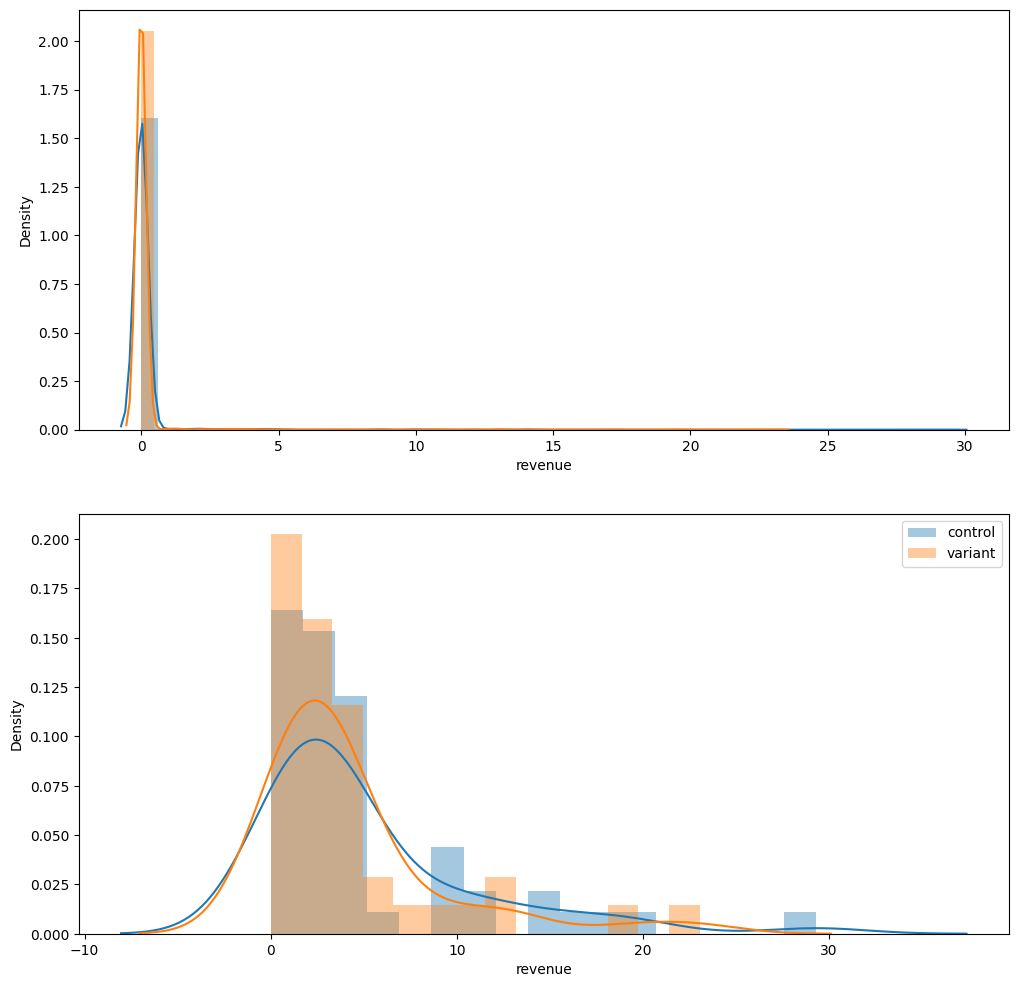

In [82]:
fig, axes = plt.subplots(2, figsize=(12, 12))

sns.distplot(data.loc[data.variant_name == 'control', 'revenue'], ax=axes[0], label='control')
sns.distplot(data.loc[data.variant_name == 'variant', 'revenue'], ax=axes[0], label='variant')

sns.distplot(data.loc[(data.variant_name == 'control') & \
    (data.revenue > 0), 'revenue'], ax=axes[1], label='control')
sns.distplot(data.loc[(data.variant_name == 'variant') & \
    (data.revenue > 0), 'revenue'], ax=axes[1], label='variant')

plt.legend()
plt.show()

## 4. A/B-тестирование для выручки

Проверим данные на нормальность и гомогенность дисперсий (тесты Шапиро-Уилка и Левена).

In [83]:
control_all = data[data.variant_name == 'control']
variant_all = data[data.variant_name == 'variant']

control_paid = data[(data.variant_name == 'control') & (data.revenue > 0)]
variant_paid = data[(data.variant_name == 'variant') & (data.revenue > 0)]

In [84]:
stat_control_all, pvalue_control_all = stats.shapiro(control_all['revenue'])
stat_variant_all, pvalue_variant_all = stats.shapiro(variant_all['revenue'])

stat_control_paid, pvalue_control_paid = stats.shapiro(control_paid['revenue'])
stat_variant_paid, pvalue_variant_paid = stats.shapiro(variant_paid['revenue'])

print("All Users Control Group:  Stat: {:.4f} Pvalue: {:.4f}".format(stat_control_all, pvalue_control_all))
print("All Users Test Group:\t  Stat: {:.4f} Pvalue: {:.4f}".format(stat_variant_all, pvalue_variant_all))

print("Paid Users Control Group: Stat: {:.4f} Pvalue: {:.4f}".format(stat_control_paid, pvalue_control_paid))
print("Paid Users Test Group:\t  Stat: {:.4f} Pvalue: {:.4f}".format(stat_variant_paid, pvalue_variant_paid))

All Users Control Group:  Stat: 0.0746 Pvalue: 0.0000
All Users Test Group:	  Stat: 0.0615 Pvalue: 0.0000
Paid Users Control Group: Stat: 0.7513 Pvalue: 0.0000
Paid Users Test Group:	  Stat: 0.7136 Pvalue: 0.0000


In [85]:
stat_all, pvalue_all = stats.levene(control_all['revenue'], variant_all['revenue'])
stat_paid, pvalue_paid = stats.levene(control_paid['revenue'], variant_paid['revenue'])

print("All Users:\t Stat: {:.4f} Pvalue: {:.4f}".format(stat_all, pvalue_all))
print("Paid Users:\t Stat: {:.4f} Pvalue: {:.4f}".format(stat_paid, pvalue_paid))

All Users:	 Stat: 1.8315 Pvalue: 0.1760
Paid Users:	 Stat: 0.6672 Pvalue: 0.4161


Видно, что на уровне 0.05 данные не нормальны, и что нельзя отбросить гипотезу о том, что дисперсии гомогенны. Поэтому воспользуемся непараметрическим критерием.

### Критерий Манна-Уитни

In [86]:
stat_all, pvalue_all = stats.mannwhitneyu(control_all['revenue'], variant_all['revenue'])
stat_paid, pvalue_paid = stats.mannwhitneyu(control_paid['revenue'], variant_paid['revenue'])

print("All Users:\t Stat: {:.0f} Pvalue: {:.4f}".format(stat_all, pvalue_all))
print("Paid Users:\t Stat: {:.2f} Pvalue: {:.4f}".format(stat_paid, pvalue_paid))

All Users:	 Stat: 2871768 Pvalue: 0.2480
Paid Users:	 Stat: 1197.00 Pvalue: 0.5314


Видно, что на уровне 0.05 статистической значимости нет. Нельзя откинуть гипотезу о различии средних значений для контроля и варианта.

Поробуем другим способом получить статистические значимые различия.

### Bootstrap

In [87]:
boot_all = []
boot_paid = []
NUM_SAMPLES = 1000

for i in range(NUM_SAMPLES):
    boot_all_mean = data.sample(frac=1, replace=True) \
        .groupby('variant_name')['revenue'].mean()
    boot_paid_mean = data[data.revenue > 0].sample(frac=1, replace=True) \
        .groupby('variant_name')['revenue'].mean()
    boot_all.append(boot_all_mean)
    boot_paid.append(boot_paid_mean)

boot_all = pd.DataFrame(boot_all)
boot_paid = pd.DataFrame(boot_paid)

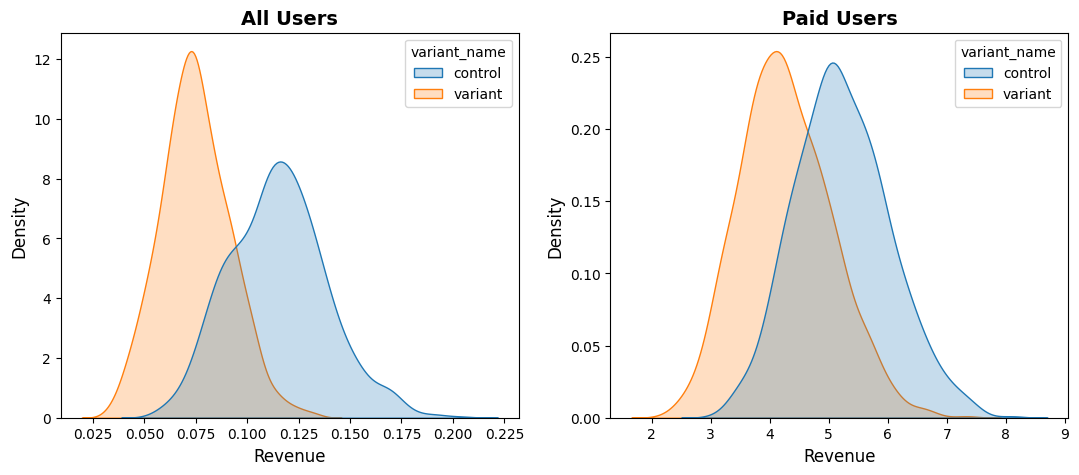

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(13,5))

sns.kdeplot(boot_all, shade=True, label='control', ax=ax1)
ax1.set_xlabel("Revenue",size=12)
ax1.set_ylabel("Density",size=12)
ax1.set_title("All Users", fontweight="bold",size=14)

sns.kdeplot(boot_paid, shade=True, label='control', ax=ax2)
ax2.set_xlabel("Revenue",size=12)
ax2.set_ylabel("Density",size=12)
ax2.set_title("Paid Users", fontweight="bold",size=14)

plt.show()

Видно, что есть какие-то различия распределений. Но для более точной оценки посмортим на распределение относительной разности.

In [89]:
boot_all['difference'] = ((boot_all.control - boot_all.variant) \
                           / boot_all.variant)
boot_paid['difference'] = ((boot_paid.control - boot_paid.variant) \
                           / boot_paid.variant)

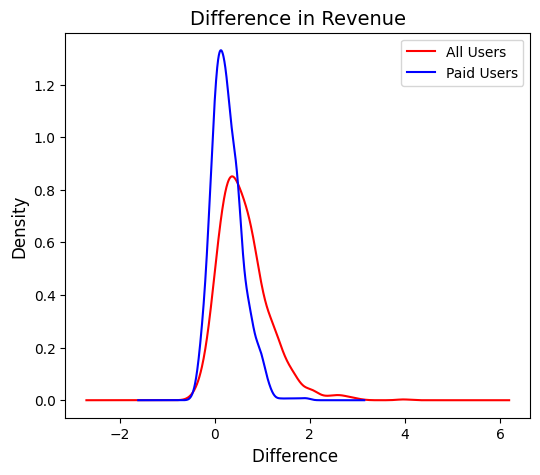

In [90]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

boot_all['difference'].plot.kde(ax=ax1, c='red', label='All Users')
boot_paid['difference'].plot.kde(ax=ax1, c='blue', label='Paid Users')

ax1.set_xlabel('Difference ', size=12)
ax1.set_ylabel('Density', size=12)
ax1.set_title('Difference in Revenue', size=14)
plt.legend()
plt.show()

Некоторые данные находятся левее нуля. Посморим, какой процент данных разности находятся левее 0.

In [91]:
prob_all = (boot_all['difference'] > 0).sum() / len(boot_all['difference'])
prob_paid = (boot_paid['difference'] > 0).sum() / len(boot_paid['difference'])

print("All Users:  {:.1f}%".format(prob_all * 100))
print("Paid Users: {:.1f}%".format(prob_paid * 100))

All Users:  92.7%
Paid Users: 80.5%


Видно, что в обоих случаях на уровне 0.05 есть данные разности, меньше 0. Таким образом нельзя однозначно сказать, что есть какой-нибудь статистически значимый результат.

Построим доверительный интервал для относительной разницы control и variant для обоих случаев.

In [92]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [93]:
all_left, all_right = stat_intervals(boot_all['difference'])
paid_left, paid_right = stat_intervals(boot_paid['difference'])

print("All Users:  [{:.3f}, {:.3f}]".format(all_left, all_right))
print("Paid Users: [{:.3f}, {:.3f}]".format(paid_left, paid_right))

All Users:  [-0.155, 1.889]
Paid Users: [-0.254, 0.982]


Видно, что 0 лежит внутри доверительных интервалов. Таким образом, получаем тот же результат.

## 5. Выводы

По результатам bootstrap и критерия Манни-Уитни не был получен какой-то статистически значимый результат. Таким образом, нет свидетельств о различии в группах для всех пользователей и только платящих пользователей.